# Data Science Project
#### Christopher Healy D00270638
#### Using Data Science to predict the popularity of Reddit posts.

# Step 1: Business Understanding
Reddit is a highly popular social media platform that is used by a wide range of individuals, entrepeneurs, and businesses. It's popularity offers the potential of a global reach to posters across an extremely diverse range of topics.

### Audience:
Many people use Reddit as a means to promote themselves or their product. This includes but is not limited to:
- Entrepeneurs advertising products to niche markets.
- Musicians/performers trying to build a platform.
- "Influencers" trying to gain recognition.

The success/popularity of a Reddit post can be measured with "Karma", a numerical value which corresponds to the total sum of ratings on a post, i.e. upvotes minus downvotes.


### Aims of the project.
Determining how a Reddit post's Karma is influenced can allow these groups to achieve the maximum reach possible. By analysing the information associated with Reddit posts and comparing it to their popularity, I hope to answer:
1. How is post length connected to post success?
2. Is date/time of posting relevant to a post's success.
3. How does the "mood" found in a post's body influence its success?
4. How do attached photos impact post performance?
5. Are there any other factors that affect how a Reddit post will be received?

Posts can be analysed to determine their "mood" from their content, this will need to be done before any machine learning models can be trained. Similarly, if post photos are included in the data they will need to be classified in some way so that their influence on post Karma can be quantitatively seen.


# Step 2: Data Mining
The data is gathered from the Reddit API using the Python Reddit API Wrapper (praw).
Post information is gathered from a variety of popular subreddits to ensure a variety of themes and audiences.
The data fetched includes a variety of information on posts submitted to the following subreddits:
- r/funny
- r/todayilearned
- r/technology
- r/aww
- r/worldnews
- r/food
- r/gaming

See separate Jupyter Notebook "DataMining.ipynb"

# Step 3 - Data Cleaning
### Datapoints used:
| Variable      | Type                | Notes                                                         |
|---------------|---------------------|---------------------------------------------------------------|
| id            | Nominal Categorical | Ignore                                                        |
| title         | Nominal Categorical | Length of title is important, otherwise ignored               |
| subreddit     | Nominal Categorical | Explanatory                                                   |
| created_utc   | Discrete Numerical  | Used to determine is_weekend, then ignored                    |
| ups           | Discrete Numerical  | Explanatory                                                   |
| downs         | Discrete Numerical  | Explanatory                                                   |
| num_comments  | Discrete Numerical  | Explanatory                                                   |
| is_video      | Nominal Categorical | Explanatory                                                   |
| selftext      | Nominal Categorical | Length of text is important, otherwise ignored                |
| is_self       | Nominal Categorical | Explanatory                                                   |
| upvote_ratio  | Continous Numerical | Explanatory                                                   |
| title_length  | Discrete Numerical  | (Calculated Manually) Explanatory                             |
| post_length   | Discrete Numerical  | (Calculated Manually) Explanatory                             |
| is_weekend_post| Nominal Categorical | Explanatory                                                   |
| score         | Discrete Numerical  | Response Variable                                             |



In [28]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt


In [29]:
#load and visualise data
reddit_data = pd.read_csv("reddit_data.csv", quotechar='"', escapechar='\\')
print("Data Info:")
print(reddit_data.info())
print("Data Head:")
print(reddit_data.head())



#check for issues in the numerical columns
print(reddit_data.describe())


#check no invalid values for categorical columns
print("\nUnique subreddits:")
print(reddit_data.subreddit.unique())
print("is_video field is only true/false?:")
print(reddit_data.is_video.unique())

print("is_self field is only true/false?:")
print(reddit_data.is_self.unique())

print("is is_weekend_post being calculated properly?:")
print(reddit_data.is_weekend_post.unique())

#ensure selftext is set to an empty string when blank
reddit_data["selftext"] = reddit_data["selftext"].fillna("")


#checking for null values in other fields
print("\nChecking for null values in df:")
fields_to_check_null = ["id", "title", "subreddit", "created_utc", "ups", "downs", "num_comments", "is_video", "is_self", "score", "upvote_ratio", "title_length", "post_length", "is_weekend_post"]
for field in fields_to_check_null:
    print(f"Null {field}:" + str(reddit_data[field].isnull().sum()))

''' 
#remove unnecessary fields
reddit_data.drop("id", axis=1, inplace=True)
reddit_data.drop("title", axis=1, inplace=True)
reddit_data.drop("created_utc", axis=1, inplace=True)
reddit_data.drop("selftext", axis=1, inplace=True)
'''


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867 entries, 0 to 6866
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6867 non-null   object 
 1   title            6867 non-null   object 
 2   subreddit        6867 non-null   object 
 3   created_utc      6867 non-null   float64
 4   ups              6867 non-null   int64  
 5   downs            6867 non-null   int64  
 6   num_comments     6867 non-null   int64  
 7   is_video         6867 non-null   bool   
 8   selftext         1227 non-null   object 
 9   is_self          6867 non-null   bool   
 10  score            6867 non-null   int64  
 11  upvote_ratio     6867 non-null   float64
 12  title_length     6867 non-null   int64  
 13  post_length      6867 non-null   int64  
 14  is_weekend_post  6867 non-null   bool   
dtypes: bool(3), float64(2), int64(6), object(4)
memory usage: 664.0+ KB
None
Data Head:
        id 

' \n#remove unnecessary fields\nreddit_data.drop("id", axis=1, inplace=True)\nreddit_data.drop("title", axis=1, inplace=True)\nreddit_data.drop("created_utc", axis=1, inplace=True)\nreddit_data.drop("selftext", axis=1, inplace=True)\n'

### Findings during data cleaning
- The info on numerical columns shown with `reddit_data.info()` show figures in reasonable ranges with no problematic max or min values.
- The categorical columns show normal value, excluding "selftext" which is unique to each post.
- When the pandas dataframe is created, blank values in the "selftext" field appeared as NaN, these needed to be changed to empty string literals.
- Investigation showed that the data had no missing / null values other than those in the selftext field, which represents a post with no textual content.

The columns of id, title, created_utc, and selftext were removed as they will not play a role in the machine learning model development.

# Step 3: Data Exploration

## Univariate Analysis
### created_utc


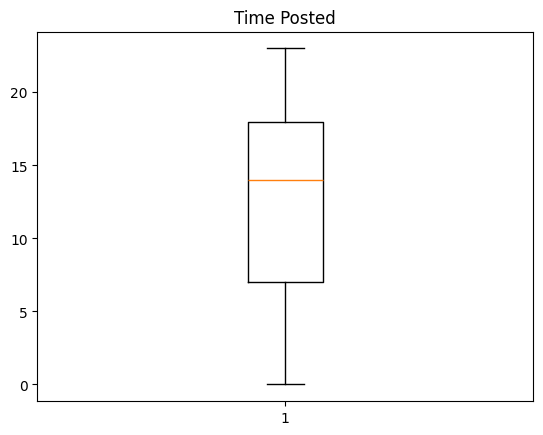

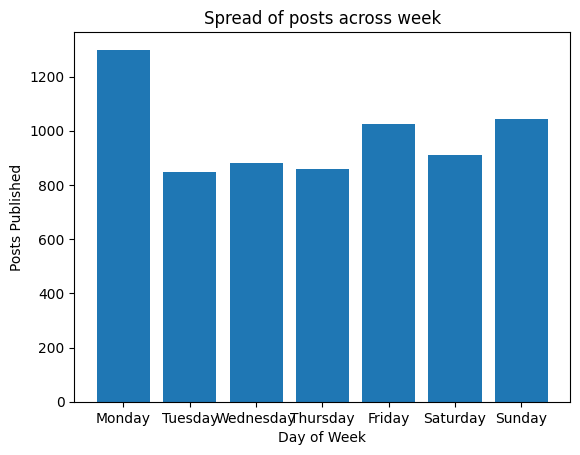

In [55]:
#plot data
#calculate average time of posting
time_as_hours = reddit_data["created_time"].dt.hour 
plt.boxplot(x=time_as_hours)
plt.title("Time Posted")
plt.show()

#calc spread across days of week
# days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_info = reddit_data["created_time"].dt.day_name()
day_counts = days_info.value_counts().reindex(days_of_week, fill_value=0)
plt.bar(day_counts.index, day_counts.values)
plt.xlabel("Day of Week")
plt.ylabel("Posts Published")
plt.title("Spread of posts across week")
plt.show()


### Analysis of utc_created
Most of the posts are published between 12pm and 3pm, there is a wide deviation however with most of the posts published between 6am and 5pm.
There is a jump in the number of posts published on Mondays, while the posts across all other days of the week are relatively similar, with a gradual increase as the week progresses.

### Ups and Downs
This deals with the number of upvotes and downvotes each post receives.


UPVOTES
Mean number of upvotes 2108.5832241153344
Standard deviation of upvotes 6550.981739088913


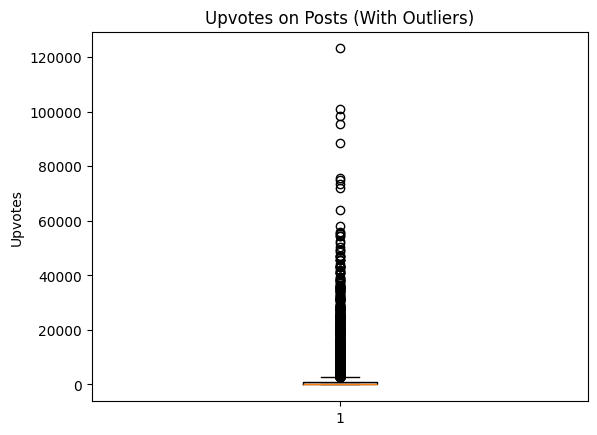

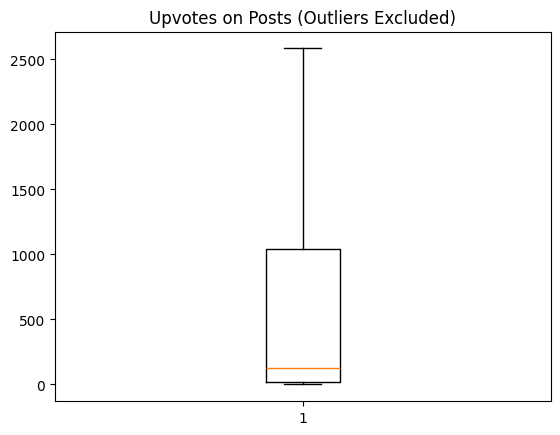

DOWNVOTES
downs
0    6867
Name: count, dtype: int64
Mean number of downvotes 0.0
Standard deviation of donwvotes 0.0
SCORE
Mean score 2108.5832241153344
Standard deviation of score 6550.981739088913


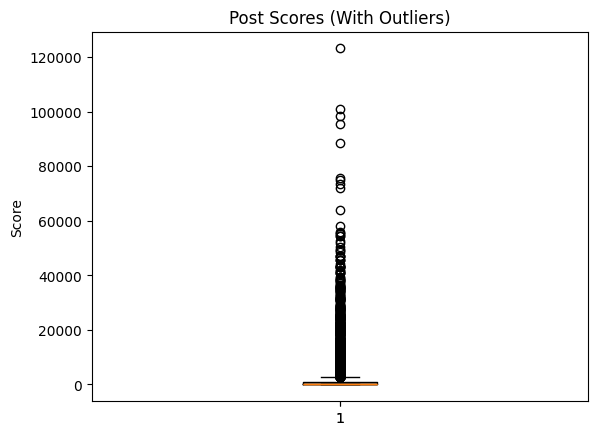

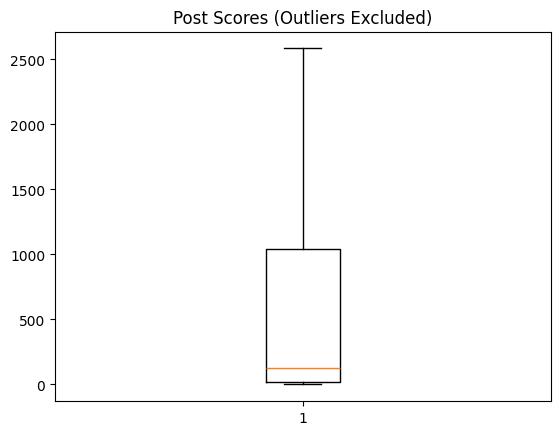

In [ ]:
#ups
print("UPVOTES")
print("Mean number of upvotes", reddit_data["ups"].mean())
print("Standard deviation of upvotes", reddit_data["ups"].std())
plt.boxplot(x=reddit_data["ups"])
plt.title("Upvotes on Posts (With Outliers)")
plt.ylabel("Upvotes")
plt.show()

plt.boxplot(x=reddit_data["ups"], showfliers=False)
plt.title("Upvotes on Posts (Outliers Excluded)")
plt.show()

#downs
print("DOWNVOTES")
print(reddit_data["downs"].value_counts()) # downvotes are essentially irrelevant / not present on most posts.

print("Mean number of downvotes", reddit_data["downs"].mean())
print("Standard deviation of donwvotes", reddit_data["downs"].std())




#score
print("SCORE")
print("Mean score", reddit_data["score"].mean())
print("Standard deviation of score", reddit_data["score"].std())
plt.boxplot(x=reddit_data["score"])
plt.title("Post Scores (With Outliers)")
plt.ylabel("Score")
plt.show()

plt.boxplot(x=reddit_data["score"], showfliers=False)
plt.title("Post Scores (Outliers Excluded)")
plt.show()


### Analysis of ups, downs, and score

It is clear from the boxplots that the average upvotes of posts is reasonably low, with the data being skewed by a handful of posts with extremely high numbers of upvotes.
With the outliers excluded, the mean number lies around 100, with posts occasional breaking through and achieving 50000+ upvotes.

Downvotes are in most posts simply not present, or not present in any amount meaningful enough to affect the data. This can likely be attributed to most posts not getting much interaction at all.

As a result of this, number of upvotes and score show essentially the same graphs, as the downvotes have a negligible effect on score in the vast majority of posts.

### Num Comments:

Mean Number of comments:  98.85291976117664
Standard deviation of number of comments:  251.07820493627585


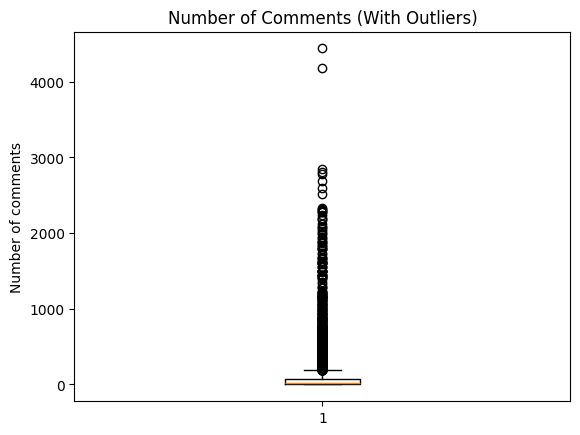

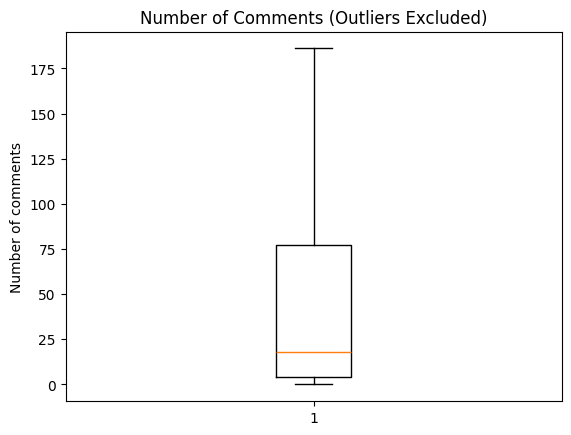

In [71]:
print("Mean Number of comments: ", reddit_data["num_comments"].mean())
print("Standard deviation of number of comments: ", reddit_data["num_comments"].std())

plt.boxplot(x=reddit_data["num_comments"])
plt.title("Number of Comments (With Outliers)")
plt.ylabel("Number of comments")
plt.show()


plt.boxplot(x=reddit_data["num_comments"], showfliers=False)
plt.title("Number of Comments (Outliers Excluded)")
plt.ylabel("Number of comments")
plt.show()






Similar to upvotes, and score. The mean number of comments posts have is skewed greatly by a group of ultra successful posts.
When outliers are excluded the average number of comments drops from 98 to approximately 10-20, with a large number receiving 0 or close to 0